In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets
 
import torchvision
from torchvision import transforms
from torchvision import models
 
import torch.nn.functional as F
import torchvision.transforms.functional as TF
 
import albumentations
 
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import time
import nibabel as nib
from tqdm import tqdm
import pandas as pd

import skimage
from skimage import img_as_ubyte, img_as_float32

from sklearn.model_selection import StratifiedShuffleSplit

from glob import glob

np.random.seed(108)
 
plt.style.use('default')
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
visualize = False

In [2]:
class Config():
  ROOT = 'cifar10'
  TRAIN_PATH = 'cifar10/train'
  VAL_PATH = 'cifar10/test'
  TEST_PATH = 'cifar10/test'
  subset_data = 1000
  patch_dim = 9
  gap = 2
  batch_size = 64
  num_epochs = 50
  lr = 0.05

In [3]:
def imshow(img,text=None,should_save=False):
    plt.figure(figsize=(10, 10))
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()  

def show_plot(iteration,loss,fname):
    plt.plot(iteration,loss)
    plt.savefig(fname)
    plt.show()

In [4]:
"""
Args:
    tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
Returns:
    Tensor: Normalized image.
"""
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
# unorm(tensor)

In [5]:
def convert_format(data, format):
  if format == 'p':
    return np.transpose(data, (0, 3, 1, 2))
  if format == 'n':
    return np.transpose(data, (0, 2, 3, 1))
  if format == '3':
    return np.transpose(data, (1, 2, 0))

In [6]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/

Mounted at /content/drive
/content/drive/My Drive


In [7]:
#############################
# Creating training dataset
#############################
df_list = [] 
classes = os.listdir(Config.TRAIN_PATH)
print(classes)
for idx, each_class in enumerate(classes):
  #print(idx)
  #print(each_class)
  images_in_each_class = glob(f'{Config.TRAIN_PATH}/{each_class}/*.png')
  #print(images_in_each_class)
  df_list += [[each_image, each_class] for each_image in images_in_each_class]

df = pd.DataFrame(data=df_list, columns=['filename', 'class'])

# Taking the classes subset
num_training_classes_subset = 10
train_classes_used = df['class'].unique()[:num_training_classes_subset]
df = df[df['class'].isin(train_classes_used)]
# df.groupby('class').count()
print(df.shape)

X, y = df['filename'], df['class']
ratio = Config.subset_data/len(X)
sss = StratifiedShuffleSplit(n_splits=5, train_size=ratio, random_state=0)
sss.get_n_splits(X, y)

print(sss)

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    stratified1000trn = train_index
    break

df_trn = df.iloc[stratified1000trn].reset_index(drop=True)
df_trn.head()

['airplane', 'frog', 'deer', 'dog', 'horse', 'bird', 'ship', 'automobile', 'truck', 'cat']
(50090, 2)
StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=None,
            train_size=0.019964064683569576)
TRAIN: 1000 TEST: 49090


,filename,class
0,cifar10/train/frog/2371.png,frog
1,cifar10/train/ship/2230.png,ship
2,cifar10/train/automobile/2979.png,automobile
3,cifar10/train/dog/0408.png,dog
4,cifar10/train/frog/1817.png,frog


In [8]:
#############################
# Creating validation dataset
#############################
df_list = [] 
classes = os.listdir(Config.VAL_PATH)
print(classes)
for idx, each_class in enumerate(classes):
  #print(idx)
  #print(each_class)
  images_in_each_class = glob(f'{Config.VAL_PATH}/{each_class}/*.png')
  #print(images_in_each_class)
  df_list += [[each_image, each_class] for each_image in images_in_each_class]

df = pd.DataFrame(data=df_list, columns=['filename', 'class'])

# Using only those classes in the dataset which are used in the training
df = df[df['class'].isin(train_classes_used)]

X, y = df['filename'], df['class']
sss = StratifiedShuffleSplit(n_splits=5, train_size=0.2, random_state=0)
sss.get_n_splits(X, y)

print(sss)

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    stratified1000val = train_index
    break

df_val = df.iloc[stratified1000val].reset_index(drop=True)
df_val['filename'] = '' + df_val['filename']
df_val[['filename', 'class']].head()

['truck', 'automobile', 'frog', 'airplane', 'ship', 'deer', 'horse', 'dog', 'bird', 'cat']
StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=None,
            train_size=0.2)
TRAIN: 2000 TEST: 8000


,filename,class
0,cifar10/test/deer/0248.png,deer
1,cifar10/test/cat/0925.png,cat
2,cifar10/test/automobile/0306.png,automobile
3,cifar10/test/dog/0063.png,dog
4,cifar10/test/airplane/0371.png,airplane


In [9]:
class MyDataset(Dataset):
  def __init__(self, patch_dim, gap, df, validate, transform=None):
    self.patch_dim, self.gap = patch_dim, gap
    self.transform = transform

    if validate:
      self.train_data = df.values
    else:
      self.train_data = df.values
  
  def get_patch_from_grid(self, image, patch_dim, gap):
    image = np.array(image)

    offset_x, offset_y = image.shape[0] - (patch_dim*3 + gap*2), image.shape[1] - (patch_dim*3 + gap*2)
    start_grid_x, start_grid_y = np.random.randint(0, offset_x), np.random.randint(0, offset_y)
    patch_loc_arr = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)]
    loc = np.random.randint(len(patch_loc_arr))
    tempx, tempy = patch_loc_arr[loc]
    
    patch_x_pt = start_grid_x + patch_dim * (tempx-1) + gap * (tempx-1)
    patch_y_pt = start_grid_y + patch_dim * (tempy-1) + gap * (tempy-1)
    random_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]

    patch_x_pt = start_grid_x + patch_dim * (2-1) + gap * (2-1)
    patch_y_pt = start_grid_y + patch_dim * (2-1) + gap * (2-1)
    uniform_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]
    
    random_patch_label = loc
    
    return uniform_patch, random_patch, random_patch_label

  def __len__(self):
    return len(self.train_data)
  
  def __getitem__(self, index):
    image = Image.open(self.train_data[index]).convert('RGB')
    uniform_patch, random_patch, random_patch_label = self.get_patch_from_grid(image, 
                                                                               self.patch_dim, 
                                                                               self.gap)
    if uniform_patch.shape[0] != 96:
        uniform_patch = skimage.transform.resize(uniform_patch, (96, 96))
        random_patch = skimage.transform.resize(random_patch, (96, 96))
        
        uniform_patch = img_as_float32(uniform_patch)
        random_patch = img_as_float32(random_patch)

    # Dropped color channels 2 and 3 and replaced with gaussian noise(std ~1/100 of the std of the remaining channel)
    #uniform_patch[:, :, 1] = np.random.normal(0.485, 0.01 * np.std(uniform_patch[:, :, 0]), (uniform_patch.shape[0],uniform_patch.shape[1]))
    #uniform_patch[:, :, 2] = np.random.normal(0.485, 0.01 * np.std(uniform_patch[:, :, 0]), (uniform_patch.shape[0],uniform_patch.shape[1]))
    #random_patch[:, :, 1] = np.random.normal(0.485, 0.01 * np.std(random_patch[:, :, 0]), (random_patch.shape[0],random_patch.shape[1]))
    #random_patch[:, :, 2] = np.random.normal(0.485, 0.01 * np.std(random_patch[:, :, 0]), (random_patch.shape[0],random_patch.shape[1]))

    random_patch_label = np.array(random_patch_label).astype(np.int64)
        
    if self.transform:
      uniform_patch = self.transform(uniform_patch)
      random_patch = self.transform(random_patch)

    return uniform_patch, random_patch, random_patch_label



##################################################
# Creating Train/Validation dataset and dataloader
##################################################

traindataset = MyDataset(Config.patch_dim, Config.gap, df_trn['filename'], False,
                         transforms.Compose([transforms.ToTensor(),
                                             ]))
trainloader = torch.utils.data.DataLoader(traindataset, 
                                          batch_size=Config.batch_size,
                                          shuffle=True,
                                          # num_workers=Config.num_workers
                                          )


valdataset = MyDataset(Config.patch_dim, Config.gap, df_val['filename'], True,
                         transforms.Compose([transforms.ToTensor(),
                                             ]))
valloader = torch.utils.data.DataLoader(valdataset,
                                        batch_size=Config.batch_size,
                                        shuffle=False)

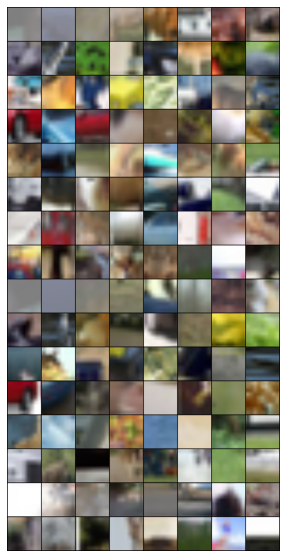

Labels: [3 7 1 3 6 6 2 4 2 1 5 6 6 5 1 4 1 2 4 6 7 6 0 4 4 7 0 7 6 3 2 6 3 2 3 7 5
 7 7 6 4 2 0 5 7 6 5 6 0 5 2 5 5 7 7 1 4 1 3 3 1 4 4 1]


In [10]:
##############################
# Visualizing training dataset
##############################

example_batch = next(iter(trainloader))
concatenated = torch.cat((unorm(example_batch[0]),unorm(example_batch[1])),0)
imshow(torchvision.utils.make_grid(concatenated))
print(f'Labels: {example_batch[2].numpy()}')

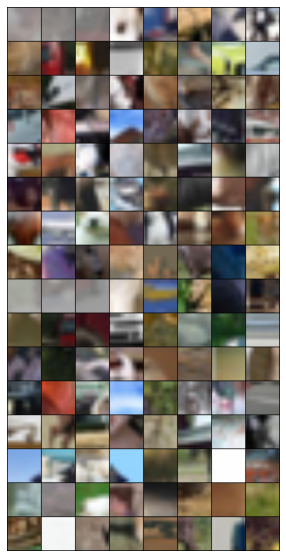

Labels: [0 6 7 2 0 3 3 6 5 3 2 6 1 0 0 6 7 7 5 4 1 3 0 3 6 2 0 3 2 4 4 7 4 5 5 7 7
 3 5 3 1 1 0 4 1 3 7 6 3 7 1 2 7 7 6 6 6 0 0 6 6 4 3 1]


In [11]:
##############################
# Visualizing validation dataset
##############################

example_batch_val = next(iter(valloader))
concatenated = torch.cat((unorm(example_batch_val[0]),unorm(example_batch_val[1])),0)
imshow(torchvision.utils.make_grid(concatenated))
print(f'Labels: {example_batch_val[2].numpy()}')

In [12]:
class AlexNetwork(nn.Module):
  def __init__(self,aux_logits = False):
      super(AlexNetwork, self).__init__()
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride = 2,padding = 2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2,padding = 1),
      )
      self.fc6 = nn.Sequential(
        nn.Linear(256,4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096),
      )
      self.fc = nn.Sequential(
        nn.Linear(2*4096,4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output


  def forward(self, uniform_patch, random_patch):
    output_fc6_uniform = self.forward_once(uniform_patch)
    output_fc6_random = self.forward_once(random_patch)
    output = torch.cat((output_fc6_uniform,output_fc6_random), 1)
    output = self.fc(output)
    return output, output_fc6_uniform, output_fc6_random

model = AlexNetwork().to(device)

In [13]:
#############################################
# Initialized Optimizer, criterion, scheduler
#############################################

if torch.cuda.is_available():
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=Config.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, verbose=True)

In [14]:
############################
# Training/Validation Engine
############################

global_trn_loss = []
global_val_loss = []
# previous_val_loss = 100

for epoch in range(Config.num_epochs):
    train_running_loss = []
    val_running_loss = []
    start_time = time.time()
    model.train()
    for idx, data in tqdm(enumerate(trainloader), total=int(len(traindataset)/Config.batch_size)):
        uniform_patch, random_patch, random_patch_label = data[0].to(device), data[1].to(device), data[2].to(device)
        optimizer.zero_grad()
        output, output_fc6_uniform, output_fc6_random = model(uniform_patch, random_patch)
        loss = criterion(output, random_patch_label)
        loss.backward()
        optimizer.step()
        
        train_running_loss.append(loss.item())
    else:
      correct = 0
      total = 0
      model.eval()
      with torch.no_grad():
        for idx, data in tqdm(enumerate(valloader), total=int(len(valdataset)/Config.batch_size)):
          uniform_patch, random_patch, random_patch_label = data[0].to(device), data[1].to(device), data[2].to(device)
          output, output_fc6_uniform, output_fc6_random = model(uniform_patch, random_patch)
          loss = criterion(output, random_patch_label)
          val_running_loss.append(loss.item())
        
          _, predicted = torch.max(output.data, 1)
          total += random_patch_label.size(0)
          correct += (predicted == random_patch_label).sum()
        print('Val Progress --- total:{}, correct:{}'.format(total, correct.item()))
        print('Val Accuracy of the network on the 10000 test images: {}%'.format(100 * correct / total))

    global_trn_loss.append(sum(train_running_loss) / len(train_running_loss))
    global_val_loss.append(sum(val_running_loss) / len(val_running_loss))

    scheduler.step(global_val_loss[-1])

    print('Epoch [{}/{}], TRNLoss:{:.4f}, VALLoss:{:.4f}, Time:{:.2f}'.format(
        epoch + 1, Config.num_epochs, global_trn_loss[-1], global_val_loss[-1],
        (time.time() - start_time) / 60))
    
    if epoch % 5 == 0:
      MODEL_SAVE_PATH = f'/content/drive/My Drive/{Config.batch_size}_{Config.num_epochs}_{Config.lr}_{Config.subset_data}_{Config.patch_dim}_{Config.gap}.pt'
      torch.save(
        {
            'epoch': Config.num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'global_trnloss': global_trn_loss,
            'global_valloss': global_val_loss
        }, MODEL_SAVE_PATH)
      #drive.mount('/content/drive', force_remount=True)

16it [06:33, 24.60s/it]
32it [12:33, 23.55s/it]


Val Progress --- total:2000, correct:274
Val Accuracy of the network on the 10000 test images: 13.700000762939453%
Epoch [1/50], TRNLoss:8912.9769, VALLoss:11989518.5992, Time:19.12


16it [00:14,  1.13it/s]
32it [00:21,  1.52it/s]


Val Progress --- total:2000, correct:239
Val Accuracy of the network on the 10000 test images: 11.950000762939453%
Epoch [2/50], TRNLoss:2.8033, VALLoss:21420612.1492, Time:0.59


16it [00:13,  1.21it/s]
32it [00:19,  1.60it/s]


Val Progress --- total:2000, correct:273
Val Accuracy of the network on the 10000 test images: 13.65000057220459%
Epoch [3/50], TRNLoss:2.1148, VALLoss:644511597211.3680, Time:0.55


16it [00:13,  1.22it/s]
32it [00:19,  1.61it/s]


Val Progress --- total:2000, correct:230
Val Accuracy of the network on the 10000 test images: 11.500000953674316%
Epoch [4/50], TRNLoss:2.1027, VALLoss:1230255879327.4404, Time:0.55


16it [00:13,  1.22it/s]
32it [00:19,  1.62it/s]


Val Progress --- total:2000, correct:240
Val Accuracy of the network on the 10000 test images: 12.000000953674316%
Epoch [5/50], TRNLoss:2.1268, VALLoss:55341887219269.4609, Time:0.55


16it [00:12,  1.23it/s]
32it [00:19,  1.62it/s]


Val Progress --- total:2000, correct:274
Val Accuracy of the network on the 10000 test images: 13.700000762939453%
Epoch [6/50], TRNLoss:2.1075, VALLoss:82495805514245.7344, Time:0.55


16it [00:14,  1.11it/s]
32it [00:20,  1.52it/s]


Val Progress --- total:2000, correct:254
Val Accuracy of the network on the 10000 test images: 12.700000762939453%
Epoch     7: reducing learning rate of group 0 to 1.5000e-02.
Epoch [7/50], TRNLoss:2.1219, VALLoss:387970281157897.3750, Time:0.59


16it [00:13,  1.21it/s]
32it [00:19,  1.61it/s]


Val Progress --- total:2000, correct:267
Val Accuracy of the network on the 10000 test images: 13.350000381469727%
Epoch [8/50], TRNLoss:4.3228, VALLoss:503473199617.7573, Time:0.55


16it [00:13,  1.23it/s]
32it [00:19,  1.62it/s]


Val Progress --- total:2000, correct:253
Val Accuracy of the network on the 10000 test images: 12.65000057220459%
Epoch [9/50], TRNLoss:9.0728, VALLoss:10588333940.2540, Time:0.55


16it [00:13,  1.23it/s]
32it [00:19,  1.62it/s]


Val Progress --- total:2000, correct:253
Val Accuracy of the network on the 10000 test images: 12.65000057220459%
Epoch [10/50], TRNLoss:2.0896, VALLoss:3864820637.9995, Time:0.55


16it [00:13,  1.23it/s]
32it [00:19,  1.63it/s]


Val Progress --- total:2000, correct:246
Val Accuracy of the network on the 10000 test images: 12.300000190734863%
Epoch [11/50], TRNLoss:2.0855, VALLoss:16224672727590.7090, Time:0.54


16it [00:14,  1.12it/s]
32it [00:21,  1.51it/s]


Val Progress --- total:2000, correct:253
Val Accuracy of the network on the 10000 test images: 12.65000057220459%
Epoch [12/50], TRNLoss:2.0966, VALLoss:6247475485290.2246, Time:0.59


16it [00:13,  1.22it/s]
32it [00:19,  1.61it/s]


Val Progress --- total:2000, correct:221
Val Accuracy of the network on the 10000 test images: 11.050000190734863%
Epoch    13: reducing learning rate of group 0 to 4.5000e-03.
Epoch [13/50], TRNLoss:2.0849, VALLoss:44445208841431.4453, Time:0.55


16it [00:13,  1.22it/s]
32it [00:19,  1.63it/s]


Val Progress --- total:2000, correct:268
Val Accuracy of the network on the 10000 test images: 13.40000057220459%
Epoch [14/50], TRNLoss:2.0810, VALLoss:254103842524304.1250, Time:0.54


16it [00:13,  1.22it/s]
32it [00:19,  1.60it/s]


Val Progress --- total:2000, correct:242
Val Accuracy of the network on the 10000 test images: 12.100000381469727%
Epoch [15/50], TRNLoss:2.0827, VALLoss:243327493046.1944, Time:0.55


16it [00:13,  1.20it/s]
32it [00:19,  1.60it/s]


Val Progress --- total:2000, correct:248
Val Accuracy of the network on the 10000 test images: 12.40000057220459%
Epoch [16/50], TRNLoss:2.0782, VALLoss:2437650934014.6426, Time:0.56


16it [00:14,  1.13it/s]
32it [00:21,  1.51it/s]


Val Progress --- total:2000, correct:267
Val Accuracy of the network on the 10000 test images: 13.350000381469727%
Epoch [17/50], TRNLoss:2.0822, VALLoss:58998368.8123, Time:0.59


16it [00:13,  1.22it/s]
32it [00:19,  1.62it/s]


Val Progress --- total:2000, correct:243
Val Accuracy of the network on the 10000 test images: 12.15000057220459%
Epoch [18/50], TRNLoss:2.0839, VALLoss:571675529245.1660, Time:0.55


16it [00:13,  1.22it/s]
32it [00:19,  1.62it/s]


Val Progress --- total:2000, correct:272
Val Accuracy of the network on the 10000 test images: 13.600000381469727%
Epoch    19: reducing learning rate of group 0 to 1.3500e-03.
Epoch [19/50], TRNLoss:4.0858, VALLoss:1541689622759.9812, Time:0.55


16it [00:12,  1.23it/s]
32it [00:19,  1.62it/s]


Val Progress --- total:2000, correct:227
Val Accuracy of the network on the 10000 test images: 11.350000381469727%
Epoch [20/50], TRNLoss:2.1586, VALLoss:841239622676.5736, Time:0.55


16it [00:13,  1.23it/s]
32it [00:20,  1.58it/s]


Val Progress --- total:2000, correct:243
Val Accuracy of the network on the 10000 test images: 12.15000057220459%
Epoch [21/50], TRNLoss:2.0807, VALLoss:573257466400.1874, Time:0.56


16it [00:14,  1.12it/s]
32it [00:21,  1.50it/s]


Val Progress --- total:2000, correct:259
Val Accuracy of the network on the 10000 test images: 12.950000762939453%
Epoch [22/50], TRNLoss:2.0799, VALLoss:42164216.3878, Time:0.59


16it [00:13,  1.23it/s]
32it [00:20,  1.59it/s]


Val Progress --- total:2000, correct:258
Val Accuracy of the network on the 10000 test images: 12.90000057220459%
Epoch [23/50], TRNLoss:2.0800, VALLoss:35693157186728.9219, Time:0.55


16it [00:13,  1.22it/s]
32it [00:20,  1.60it/s]


Val Progress --- total:2000, correct:216
Val Accuracy of the network on the 10000 test images: 10.800000190734863%
Epoch [24/50], TRNLoss:2.0796, VALLoss:133701084097502.7656, Time:0.55


16it [00:13,  1.22it/s]
32it [00:19,  1.62it/s]


Val Progress --- total:2000, correct:277
Val Accuracy of the network on the 10000 test images: 13.850000381469727%
Epoch    25: reducing learning rate of group 0 to 4.0500e-04.
Epoch [25/50], TRNLoss:2.0796, VALLoss:39436692898231.7188, Time:0.55


16it [00:13,  1.23it/s]
32it [00:20,  1.57it/s]


Val Progress --- total:2000, correct:249
Val Accuracy of the network on the 10000 test images: 12.450000762939453%
Epoch [26/50], TRNLoss:2.0803, VALLoss:60834392734588.5469, Time:0.56


16it [00:14,  1.10it/s]
32it [00:21,  1.50it/s]


Val Progress --- total:2000, correct:247
Val Accuracy of the network on the 10000 test images: 12.350000381469727%
Epoch [27/50], TRNLoss:2.0809, VALLoss:100293823951465.0312, Time:0.60


16it [00:13,  1.21it/s]
32it [00:20,  1.60it/s]


Val Progress --- total:2000, correct:277
Val Accuracy of the network on the 10000 test images: 13.850000381469727%
Epoch [28/50], TRNLoss:2.0798, VALLoss:150254563034844.4375, Time:0.55


16it [00:13,  1.22it/s]
32it [00:19,  1.62it/s]


Val Progress --- total:2000, correct:250
Val Accuracy of the network on the 10000 test images: 12.500000953674316%
Epoch [29/50], TRNLoss:2.0808, VALLoss:5586285667303.8672, Time:0.55


16it [00:13,  1.19it/s]
32it [00:20,  1.57it/s]


Val Progress --- total:2000, correct:247
Val Accuracy of the network on the 10000 test images: 12.350000381469727%
Epoch [30/50], TRNLoss:2.0803, VALLoss:162871524166.6804, Time:0.56


16it [00:13,  1.21it/s]
32it [00:20,  1.58it/s]


Val Progress --- total:2000, correct:240
Val Accuracy of the network on the 10000 test images: 12.000000953674316%
Epoch    31: reducing learning rate of group 0 to 1.2150e-04.
Epoch [31/50], TRNLoss:2.0800, VALLoss:33907344321487.8477, Time:0.56


16it [00:14,  1.10it/s]
32it [00:21,  1.47it/s]


Val Progress --- total:2000, correct:247
Val Accuracy of the network on the 10000 test images: 12.350000381469727%
Epoch [32/50], TRNLoss:2.0801, VALLoss:78188670653212.4375, Time:0.61


16it [00:13,  1.21it/s]
32it [00:19,  1.62it/s]


Val Progress --- total:2000, correct:246
Val Accuracy of the network on the 10000 test images: 12.300000190734863%
Epoch [33/50], TRNLoss:2.0792, VALLoss:22125776317045.4453, Time:0.55


16it [00:12,  1.23it/s]
32it [00:19,  1.63it/s]


Val Progress --- total:2000, correct:263
Val Accuracy of the network on the 10000 test images: 13.15000057220459%
Epoch [34/50], TRNLoss:2.0793, VALLoss:21338929440374.6602, Time:0.54


16it [00:12,  1.26it/s]
32it [00:19,  1.66it/s]


Val Progress --- total:2000, correct:275
Val Accuracy of the network on the 10000 test images: 13.750000953674316%
Epoch [35/50], TRNLoss:2.0795, VALLoss:66610312564969.8047, Time:0.54


16it [00:12,  1.26it/s]
32it [00:19,  1.66it/s]


Val Progress --- total:2000, correct:251
Val Accuracy of the network on the 10000 test images: 12.550000190734863%
Epoch [36/50], TRNLoss:2.0791, VALLoss:130141620368087.1875, Time:0.53


16it [00:14,  1.14it/s]
32it [00:20,  1.55it/s]


Val Progress --- total:2000, correct:265
Val Accuracy of the network on the 10000 test images: 13.250000953674316%
Epoch    37: reducing learning rate of group 0 to 3.6450e-05.
Epoch [37/50], TRNLoss:2.0800, VALLoss:25034412006043.7500, Time:0.58


16it [00:12,  1.27it/s]
32it [00:19,  1.62it/s]


Val Progress --- total:2000, correct:241
Val Accuracy of the network on the 10000 test images: 12.050000190734863%
Epoch [38/50], TRNLoss:2.0794, VALLoss:53871213356159.6328, Time:0.54


16it [00:13,  1.21it/s]
32it [00:19,  1.61it/s]


Val Progress --- total:2000, correct:264
Val Accuracy of the network on the 10000 test images: 13.200000762939453%
Epoch [39/50], TRNLoss:2.0793, VALLoss:30120192929604.8984, Time:0.55


16it [00:13,  1.23it/s]
32it [00:19,  1.61it/s]


Val Progress --- total:2000, correct:273
Val Accuracy of the network on the 10000 test images: 13.65000057220459%
Epoch [40/50], TRNLoss:2.0792, VALLoss:7024687850779.2617, Time:0.55


16it [00:12,  1.24it/s]
32it [00:19,  1.64it/s]


Val Progress --- total:2000, correct:250
Val Accuracy of the network on the 10000 test images: 12.500000953674316%
Epoch [41/50], TRNLoss:2.0785, VALLoss:52190467992.6679, Time:0.54


16it [00:14,  1.12it/s]
32it [00:20,  1.54it/s]


Val Progress --- total:2000, correct:248
Val Accuracy of the network on the 10000 test images: 12.40000057220459%
Epoch [42/50], TRNLoss:2.0796, VALLoss:2508254159839.4023, Time:0.59


16it [00:12,  1.24it/s]
32it [00:19,  1.65it/s]


Val Progress --- total:2000, correct:254
Val Accuracy of the network on the 10000 test images: 12.700000762939453%
Epoch    43: reducing learning rate of group 0 to 1.0935e-05.
Epoch [43/50], TRNLoss:2.0804, VALLoss:863141418134513.8750, Time:0.54


16it [00:12,  1.23it/s]
32it [00:19,  1.64it/s]


Val Progress --- total:2000, correct:241
Val Accuracy of the network on the 10000 test images: 12.050000190734863%
Epoch [44/50], TRNLoss:2.0796, VALLoss:38516764049.2066, Time:0.54


16it [00:12,  1.25it/s]
32it [00:19,  1.65it/s]


Val Progress --- total:2000, correct:279
Val Accuracy of the network on the 10000 test images: 13.950000762939453%
Epoch [45/50], TRNLoss:2.0794, VALLoss:22861789356.4165, Time:0.54


16it [00:13,  1.20it/s]
32it [00:20,  1.59it/s]


Val Progress --- total:2000, correct:246
Val Accuracy of the network on the 10000 test images: 12.300000190734863%
Epoch [46/50], TRNLoss:2.0797, VALLoss:606897142482.5081, Time:0.56


16it [00:14,  1.12it/s]
32it [00:20,  1.55it/s]


Val Progress --- total:2000, correct:253
Val Accuracy of the network on the 10000 test images: 12.65000057220459%
Epoch [47/50], TRNLoss:2.0799, VALLoss:988896009384.6672, Time:0.58


16it [00:12,  1.23it/s]
32it [00:19,  1.62it/s]


Val Progress --- total:2000, correct:261
Val Accuracy of the network on the 10000 test images: 13.050000190734863%
Epoch [48/50], TRNLoss:2.0793, VALLoss:1483021976028.8364, Time:0.55


16it [00:13,  1.22it/s]
32it [00:19,  1.61it/s]


Val Progress --- total:2000, correct:224
Val Accuracy of the network on the 10000 test images: 11.200000762939453%
Epoch    49: reducing learning rate of group 0 to 3.2805e-06.
Epoch [49/50], TRNLoss:2.0793, VALLoss:638785304898.3563, Time:0.55


16it [00:13,  1.23it/s]
32it [00:19,  1.62it/s]

Val Progress --- total:2000, correct:257
Val Accuracy of the network on the 10000 test images: 12.850000381469727%
Epoch [50/50], TRNLoss:2.0799, VALLoss:2561423756703.9819, Time:0.55
